# Annual Business Survey 2019
## Group Assessment - Module 08

## ETL Report
#### Introduction

- In this portion, we will dicuss the problems or questions that we are trying to solve or answer. 
    We will identify the sources of our data and describe why the data needs to be transformed.
    
#### Data Sources

- In this portion we will be more specific about where we found the data, when we accessed it, and we will cite any sources.

#### Extraction

- In this portion we will show how we got our data, show aspects of the data consumption process and indicate the order of the process.

In [19]:
import pandas as pd

tech_variables = 'https://api.census.gov/data/2018/abstcb/variables.html'
owner_variables = 'https://api.census.gov/data/2018/abscbo/variables.html'
characteristics_variables = 'https://api.census.gov/data/2018/abscb/variables.html'
company_summary_variables = 'https://api.census.gov/data/2018/abscs/variables.html'


### Get Tables of Variables

In [20]:
tech_vars = pd.read_html(tech_variables)[0]
owner_vars = pd.read_html(owner_variables)[0]
characteristic_vars = pd.read_html(characteristics_variables)[0]
company_summary_vars = pd.read_html(company_summary_variables)[0]

tech_vars = tech_vars[[_ for _ in tech_vars.columns[:2]]]
owner_vars = owner_vars[[_ for _ in owner_vars.columns[:2]]]
characteristic_vars = characteristic_vars[[_ for _ in characteristic_vars.columns[:2]]]
company_summary_vars = company_summary_vars[[_ for _ in company_summary_vars.columns[:2]]] 

tech_vars.rename(columns = {'Label': 'Tech Labels'}, inplace = True)
owner_vars.rename(columns = {'Label': 'Owner Labels'}, inplace = True)
characteristic_vars.rename(columns = {'Label': 'Characteristic Labels'}, inplace = True)
company_summary_vars.rename(columns = {'Label': 'Company Summary Labels'}, inplace = True)

In [123]:
grouped_tables = pd.merge(tech_vars, owner_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, characteristic_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, company_summary_vars , left_on = 'Name', right_on = 'Name', how = 'outer')

grouped_tables.fillna("-", inplace = True)

grouped_tables = grouped_tables[(~grouped_tables['Tech Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Owner Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Characteristic Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Company Summary Labels'].str.contains('Standard error|standard error'))]

grouped_tables.reset_index(drop = True, inplace = True)
grouped_tables = grouped_tables[:-2].sort_values(by = 'Name')
grouped_tables = grouped_tables[(~grouped_tables['Name'].str.contains('variables'))].reset_index(drop = True)

# In the segment of code below, we are creating a list of variables that are common to all tables.
# For example, OWNER_ETH is also noted as ETH_GROUP, so I am creating a new variable that indicates they are similar.
def clean_var_names(var_name):
    if 'OWNER_' in var_name:
        var_name = var_name.replace('OWNER_',"")
    elif ('OWN' in var_name and 'CHAR' not in var_name and 'PDEMP' not in var_name):
        var_name = var_name.replace('OWN',"")
    
    if var_name in ['ETH','RACE','SEX','VET']:
        var_name = var_name + "_GROUP"
        
    return var_name

grouped_tables['Common_Vars'] = grouped_tables['Name'].apply(lambda x: clean_var_names(x))
grouped_tables = grouped_tables[['Name','Common_Vars','Tech Labels','Owner Labels','Characteristic Labels','Company Summary Labels']]
grouped_tables.sort_values(by = 'Common_Vars', inplace = True)

##### Define which variables are common and could be used to merge.

In [127]:
possible_merge_options = grouped_tables[grouped_tables.apply(lambda x: not x.str.contains("-").any(), axis = 1)]
common_vars = [_.lower() for _ in possible_merge_options.Common_Vars.tolist()]

In [128]:
print("\n------ Displaying top 10 rows of variable tables. ------\n")
grouped_tables.head(10)


------ Displaying top 10 rows of variable tables. ------



,Name,Common_Vars,Tech Labels,Owner Labels,Characteristic Labels,Company Summary Labels
0,BUSCHAR,BUSCHAR,-,-,Business characteristic code,-
1,CBSA,CBSA,-,Geography,Geography,Geography
2,EMP,EMP,Number of employees,-,Number of employees,Number of employees
3,EMPSZFI,EMPSZFI,-,-,Employment size of firms code,Employment size of firms code
4,EMP_PCT,EMP_PCT,Percent of employees (%),-,Percent of employees (%),-
22,OWNER_ETH,ETH_GROUP,-,Ethnicity code,-,-
5,ETH_GROUP,ETH_GROUP,Ethnicity code,-,Ethnicity code,Ethnicity code
6,FACTORS_P,FACTORS_P,Factors adversely affecting technology product...,-,-,-
7,FACTORS_U,FACTORS_U,Factors adversely affecting technology use code,-,-,-
8,FIRMPDEMP,FIRMPDEMP,Number of employer firms,-,Number of employer firms,Number of employer firms


##### Define which variables will be requested from API

In [132]:
# grouped_tables.sort_values(by = 'Name', ascending = False)
vars_of_interest = [
    'NAICS2017',
    'YIBSZFI',
    'SEX',
    'QDESC',
    'NSFSZFI',
    'GEO_ID',
    'RACE_GROUP',
    'BUSCHAR',
    'OWNER_RACE',
    'OWNER_SEX',
    'OWNPDEMP',
    'FIRMPDEMP',
    'OWNCHAR',
    'TECHUSE'
]
target_subset = grouped_tables[(grouped_tables['Name'].isin(vars_of_interest))]
target_subset = target_subset[['Name','Company Summary Labels','Characteristic Labels','Owner Labels','Tech Labels']]

### Build variable strings to pass to api call


In [133]:
no_label = ['OWNPDEMP_LABEL','GEO_ID_LABEL','FIRMPDEMP_LABEL']
variable_dict = {}
for i,label in enumerate(target_subset.columns[1:]):
    variable_list = []
    for item in target_subset[(target_subset[label] != "-")].Name.tolist():
        variable_list.append(item)
        variable_list.append(f'{item}_LABEL')
    variable_list = [_ for _ in variable_list if _ not in no_label]#, 'QDESC_LABEL']]
    in_table = "NAME," + ",".join(variable_list)
    variable_dict[i] = in_table
variable_dict


{0: 'NAME,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL',
 1: 'NAME,BUSCHAR,BUSCHAR_LABEL,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL',
 2: 'NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNCHAR,OWNCHAR_LABEL,OWNPDEMP,QDESC,QDESC_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL',
 3: 'NAME,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,TECHUSE,TECHUSE_LABEL'}

In [134]:
# industry_code = '61'
# qdesc1 = 'B27'

links = [
    f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]}&for=state:*',
    f'https://api.census.gov/data/2018/abscb?get={variable_dict[1]}&for=state:*',
    f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]}&for=us:*&for=QDESC_LABEL=YRACQBUS',
    f'https://api.census.gov/data/2018/abstcb?get={variable_dict[3]}&for=state:*',
]

def get_data_frame(url):
    print(url,'\n')
    return pd.read_csv(url)

# In case of errors, to go to the link of what was attempted...
def view_links():
    for link in links:
        print(link,"\n")
#view_links() # <---- Uncomment this line to view links

### The cell below is where the dataframes are first stored.

In [135]:
comp_sum_df = get_data_frame(links[0]) # Company Summary
bus_char_df = business_char_df = get_data_frame(links[1]) # Business Characteristics
bus_own_df = business_own_df = get_data_frame(links[2]) # Business Owners
bus_tech_df = get_data_frame(links[3]) # Business Tech   

https://api.census.gov/data/2018/abscs?get=NAME,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL&for=state:* 

https://api.census.gov/data/2018/abscb?get=NAME,BUSCHAR,BUSCHAR_LABEL,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL&for=state:* 

https://api.census.gov/data/2018/abscbo?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNCHAR,OWNCHAR_LABEL,OWNPDEMP,QDESC,QDESC_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS 

https://api.census.gov/data/2018/abstcb?get=NAME,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,TECHUSE,TECHUSE_LABEL&for=state:* 



In [136]:
df_collection = [comp_sum_df, bus_char_df, bus_own_df, bus_tech_df]    
df_names = ['comp_sum_df', 'bus_char_df', 'bus_own_df', 'bus_tech_df']   

### Clean DataFrames

In [137]:
drop_list = [
    'race_group','sex','yibszfi','qdesc','buschar',
    'owner_race','owner_sex','us','ownchar'
]

for df in df_collection:
    column_names = [_ for _ in df.columns.tolist()]
    new_column_names = [_.replace("[[","").replace('"',"").replace("]","").lower() for _ in column_names]

    df.columns = new_column_names
    df.drop(columns = [_ for _ in new_column_names if ('unnamed' in _ or _ in drop_list)],inplace = True)
    df['name'] = df['name'].apply(lambda x: x.replace("[","").replace('"',""))
    
    if 'sex_label' in df.columns:
        df.rename(columns = {'sex_label': 'gender'}, inplace = True)
    
    if 'owner_sex_label' in df.columns:
        df.rename(columns = {'owner_sex_label': 'gender'}, inplace = True)
    
    if 'naics2017_label' in df.columns:
        df.rename(columns = {'naics2017_label': 'industry'}, inplace = True)
        
    if 'naics2017' in df.columns:
        df.rename(columns = {'naics2017': 'industry_code'}, inplace = True)

### Display some info about dataframes.

In [138]:
# First display all columns together
print("(Columns are sorted alphabetically...)")
for i,df in enumerate(df_collection):
    print(f'DATAFRAME: {df_names[i]}\n COMMON: {", ".join(_ for _ in sorted(df.columns.tolist()) if _ in common_vars)}\n')

print("\n(Columns are sorted alphabetically...)")
for i,df in enumerate(df_collection):
    print(f'DATAFRAME: {df_names[i]}\n  COLUMNS: {", ".join(sorted(df.columns.tolist()))}\n')
    
for i,df in enumerate(df_collection):
    print('\n############# NEW DATAFRAME ################')
    print('Displaying column value counts where there are fewer than 10 unique values in the column.')
    print(f'\n---  DataFrame: {df_names[i]} ---------------------')
    print(f'Columns: {", ".join(df.columns.tolist())}')
    for column in df:
        if len(df[column].unique().tolist()) < 10:
            print(df[column].value_counts())
            print("")
    print('############# END OF DATAFRAME INFO ################\n\n')

(Columns are sorted alphabetically...)
DATAFRAME: comp_sum_df
 COMMON: geo_id, state

DATAFRAME: bus_char_df
 COMMON: geo_id, state

DATAFRAME: bus_own_df
 COMMON: geo_id

DATAFRAME: bus_tech_df
 COMMON: geo_id, state


(Columns are sorted alphabetically...)
DATAFRAME: comp_sum_df
  COLUMNS: firmpdemp, gender, geo_id, industry, industry_code, name, race_group_label, state, yibszfi_label

DATAFRAME: bus_char_df
  COLUMNS: buschar_label, firmpdemp, gender, geo_id, industry, industry_code, name, qdesc_label, race_group_label, state, yibszfi_label

DATAFRAME: bus_own_df
  COLUMNS: gender, geo_id, industry, industry_code, name, ownchar_label, owner_race_label, ownpdemp, qdesc_label

DATAFRAME: bus_tech_df
  COLUMNS: firmpdemp, gender, geo_id, industry, industry_code, name, nsfszfi, nsfszfi_label, race_group_label, state, techuse, techuse_label


############# NEW DATAFRAME ################
Displaying column value counts where there are fewer than 10 unique values in the column.

---  DataFr

In [43]:
comp_sum_df[['industry_code','industry']].drop_duplicates()

,industry_code,industry
0,21,"Mining, quarrying, and oil and gas extraction"
13,23,Construction
22,31-33,Manufacturing
31,48-49,Transportation and warehousing
38,00,Total for all sectors
82,44-45,Retail trade
118,11,"Agriculture, forestry, fishing and hunting"
230,22,Utilities
272,42,Wholesale trade
735,51,Information


In [44]:
def jeds_first_plot(comp_sum_df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    targ1 = 23
    targ2 = 52
    targ1,targ2 = str(targ1), str(targ2)

    gender_by_state_cs = comp_sum_df[
        (comp_sum_df['industry_code'].isin([targ1, targ2]))
        ].groupby(by = ['name','industry','gender']
                 )[['gender']].agg('count').rename(columns = {'gender': 'gender_count'}).reset_index()

    gender_by_state_cs.sort_values(by = ['name', 'industry', 'gender'], inplace = True)
    gs = gender_by_state_cs

    print('NOTE: Ratios are for each set of observations and not industry specific.')
    print('Building Plots... Please Wait...')
    fig, axs = plt.subplots(51,1, figsize=(15,200), sharex = False)
    fig.suptitle('Ownership Gender in a Subset of Industries by State', fontsize = 30)
    colors = {'Female':'#FD6320','Male':'#9567FE', 'Equally male/female': '#919584'}

    states = sorted(comp_sum_df.name.unique().tolist())
    for i, state in enumerate(states):
        axs[i].set_title(state, fontsize = 20)

        subset = gs[
                (gs['name'] == state) &
                (gs['gender'] != 'Total')
            ] 
        industries = sorted(subset.industry.unique().tolist())
        sns.barplot(data = subset, x = 'industry', y = 'gender_count', 
                    ax = axs[i], hue = 'gender', 
                    palette = colors, 
                    edgecolor = 'black')

        axs[i].set_ylabel('')
        axs[i].set_xlabel('')

        font = {'color': 'w',
                'weight': 'bold',
                'size': 14,
               }
        if i % 3 == 0:
            axs[i].text(-0.36,0.65, "Equal Gender\nOwnership", fontdict = font)
            axs[i].text(-0.05,0.65, "Female", fontdict = font)
            axs[i].text(0.23,0.65, "Male", fontdict = font)

        axs[i].get_legend().remove()
        axs[i].tick_params(left = False)
        axs[i].set_yticklabels('')

        gender_count = subset['gender_count'].sum()
        for c in axs[i].containers:
            labels = [
                f'{(h/gender_count)*100:0.1f}%' if (
                    h := v.get_height()) > 0 else "" for v in c
            ]

            axs[i].bar_label(c,labels=labels,label_type = 'edge',fontsize = 17,color= 'black')
        axs[i].tick_params(axis = 'x', labelsize = 18)

    plt.tight_layout()
    plt.subplots_adjust(hspace = 1,top = 0.97)
    sns.despine(left = True, bottom = True)
    print('Done... Displaying Plots...')

    #plt.savefig('gender_ownership_state.pdf')

# jeds_first_plot(comp_sum_df)  ## Uncomment to run the plot

In [49]:
reason_owned = bus_own_df[
    (bus_own_df['qdesc_label'] == 'REASONOWN') &
    (~bus_own_df['industry'].str.contains('Total')) &
    (~bus_own_df['gender'].str.contains('All')) &
    (bus_own_df['ownchar_label'].str.contains(':'))]

In [50]:
reason_owned[['reason','importance']] = reason_owned.apply(lambda row: row['ownchar_label'].split(":"), axis = 1, result_type = 'expand')

C:\Users\Work\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
reason_owned

,name,geo_id,industry_code,industry,owner_race_label,gender,ownpdemp,qdesc_label,ownchar_label,reason,importance
3090,United States,0100000US,11,"Agriculture, forestry, fishing and hunting",All owners of respondent firms,Male,7333,REASONOWN,Best avenue for ideas: Very important,Best avenue for ideas,Very important
3091,United States,0100000US,11,"Agriculture, forestry, fishing and hunting",All owners of respondent firms,Male,10770,REASONOWN,Couldn't find a job: Not important,Couldn't find a job,Not important
3092,United States,0100000US,11,"Agriculture, forestry, fishing and hunting",All owners of respondent firms,Male,2062,REASONOWN,Couldn't find a job: Somewhat important,Couldn't find a job,Somewhat important
3093,United States,0100000US,11,"Agriculture, forestry, fishing and hunting",All owners of respondent firms,Male,721,REASONOWN,Couldn't find a job: Very important,Couldn't find a job,Very important
3094,United States,0100000US,11,"Agriculture, forestry, fishing and hunting",All owners of respondent firms,Male,4321,REASONOWN,Work for self: Not important,Work for self,Not important
...,...,...,...,...,...,...,...,...,...,...,...
46068,United States,0100000US,99,Industries not classified,White,Female,935,REASONOWN,Carry on family business: Somewhat important,Carry on family business,Somewhat important
46069,United States,0100000US,99,Industries not classified,White,Female,1516,REASONOWN,Carry on family business: Very important,Carry on family business,Very important
46070,United States,0100000US,99,Industries not classified,White,Female,1428,REASONOWN,Help my community: Not important,Help my community,Not important
46071,United States,0100000US,99,Industries not classified,White,Female,1531,REASONOWN,Help my community: Somewhat important,Help my community,Somewhat important


In [52]:
reason_owned = reason_owned[['industry','gender','reason','importance','ownpdemp']]

In [53]:
reason_owned

,industry,gender,reason,importance,ownpdemp
3090,"Agriculture, forestry, fishing and hunting",Male,Best avenue for ideas,Very important,7333
3091,"Agriculture, forestry, fishing and hunting",Male,Couldn't find a job,Not important,10770
3092,"Agriculture, forestry, fishing and hunting",Male,Couldn't find a job,Somewhat important,2062
3093,"Agriculture, forestry, fishing and hunting",Male,Couldn't find a job,Very important,721
3094,"Agriculture, forestry, fishing and hunting",Male,Work for self,Not important,4321
...,...,...,...,...,...
46068,Industries not classified,Female,Carry on family business,Somewhat important,935
46069,Industries not classified,Female,Carry on family business,Very important,1516
46070,Industries not classified,Female,Help my community,Not important,1428
46071,Industries not classified,Female,Help my community,Somewhat important,1531


In [59]:
grouped_reason = reason_owned.groupby(
    by = ['industry','reason','importance'])[['ownpdemp']].agg(
    responses = ('ownpdemp', 'sum')
)
grouped_reason.head(10)

responses
industry                        reason                   importance                    
Accommodation and food services Balance work and family   Not important          176731
                                                          Somewhat important     358136
                                                          Very important         569109
                                Best avenue for ideas     Not important          183753
                                                          Somewhat important     391204
                                                          Very important         531802
                                Carry on family business  Not important          610298
                                                          Somewhat important     233917
                                                          Very important         259629
                                Couldn't find a job       Not important          749862

In [76]:
subset = grouped_reason.reset_index()
accom_subset = subset[(subset['industry'].str.contains('inanc'))]
accom_subset.head(1)

,industry,reason,importance,responses
216,Finance and insurance,Balance work and family,Not important,60218


In [73]:
import plotly.express as px

fig = px.bar(accom_subset, x = 'reason', y = 'responses', color = 'importance',
            width = 800, height = 400)

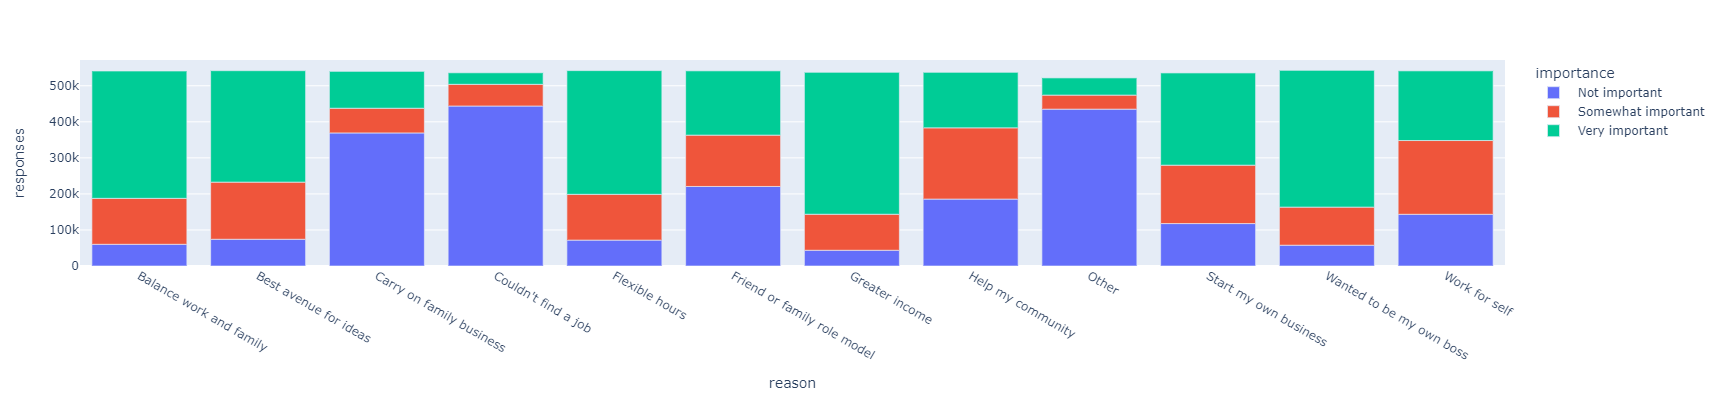

In [75]:
fig.show()